In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
from itertools import product
from tqdm import tqdm

from pyqumo.fitting.johnson89 import fit_mern2
from pyqumo.stats import get_cv, get_skewness, get_noncentral_m2, get_noncentral_m3
from pyqumo.random import HyperErlang

In [3]:
matplotlib.rcParams['pcolor.shading'] = 'auto'

In [4]:
def x2cv(x: float) -> float:
    """Get CV value from c-1/c value.
    """
    return (x + pow(x**2 + 4, 0.5)) / 2

In [5]:
GRID_SIZE = 100
X = np.linspace(-10, 10, GRID_SIZE)  # c - 1/c values
Y = np.linspace(-10, 10, GRID_SIZE)  # gamma (skewness) values, not all feasible
CV = np.asarray([x2cv(x) for x in X])
PLANE_SHAPE = (GRID_SIZE, GRID_SIZE)
COORDS = list(product(range(GRID_SIZE), range(GRID_SIZE)))
MEAN = 1.0

## Study of ACPH(2)

In [6]:
M2 = [get_noncentral_m2(MEAN, cv) for cv in CV]
# M3 = [[
#    get_noncentral_m3(MEAN, cv, skew) 
#    if skew >= cv - 1/cv else np.nan 
#    for skew in Y
#] for cv in CV]

In [7]:
from pyqumo.fitting.acph2 import get_acph2_m2_min, get_acph2_m3_bounds

BG_CMAP = plt.get_cmap('Pastel2')
FG_CMAP = plt.get_cmap('viridis')

def plot_acph2_boundary_in_cv2_m3_plane(ax, mean=1, step=0.002):
    X = np.arange(0.4, 1.1, step)  # C^2
    Y = np.arange(2, 8, step)      # M3
    F = np.zeros((len(Y), len(X)))

    m2_min = get_acph2_m2_min(mean)

    for i, cv2 in enumerate(X):
        m2 = get_noncentral_m2(mean, cv2**.5)
        if m2 < m2_min:
            for j in range(len(Y)):
                F[j, i] = np.nan
            continue
        min_m3, max_m3 = get_acph2_m3_bounds(mean, m2)
        for j, m3 in enumerate(Y):
            F[j, i] = 1 if min_m3 <= m3 <= max_m3 else np.nan
    
    ax.pcolormesh(X, Y, F, cmap=BG_CMAP)
    ax.grid()
    ax.set_xlabel(r'Squared coef. of variation ($c^2$)', fontsize=14)
    ax.set_ylabel(r'Third non-central moment ($\mathbb{E}X^3$)', fontsize=14)

In [31]:
def plot_acph2_boundary_in_normal_plane(ax, mean=1, step=0.002, scale=1.0):
    xmin = -2.0
    xmax = 3
    ymin = -0.5
    ymax = 6
    
    X = np.arange(xmin, xmax, step)  # cv - 1/cv
    Y = np.arange(ymin, ymax, step)  # skew
    CV = np.asarray([x2cv(x) for x in X])
    F = np.zeros((len(Y), len(X)))
    
    m2_min = get_acph2_m2_min(mean)
    cv_min = get_cv(mean, m2_min)
    x_min = cv_min - 1/cv_min
    
    Xs = np.asarray([x for x in X if x_min <= x <= 0])
    Cs = np.asarray([x2cv(x) for x in Xs])
    G1 = (6*Cs**2 - 4 + 3 * 2**0.5 * (1 - Cs**2)**1.5) / Cs**3
    G2 = 3/Cs - 1/Cs**3
    
    Xl = np.asarray([x for x in X if x >= 0])
    Cl = np.asarray([x2cv(x) for x in Xl])
    G3 = 1.5*Cl + 0.5/Cl**3
    
    Xv = [0, 0]
    G4 = [2, ymax]  # constant: lowest point states for Exp dist.

    for i, x in enumerate(X):
        cv = CV[i]
        m2 = get_noncentral_m2(mean, cv)
        if m2 < m2_min:
            for j in range(len(Y)):
                F[j, i] = np.nan
            continue
        min_m3, max_m3 = get_acph2_m3_bounds(mean, m2)
        for j, y in enumerate(Y):
            m3 = get_noncentral_m3(mean, cv, y)
            F[j, i] = 1 if min_m3 <= m3 <= max_m3 else np.nan

    ax.pcolormesh(X, Y, F, cmap=BG_CMAP)
    ax.plot(Xs, G1, color=FG_CMAP(.4))
    ax.plot(Xs, G2, color=FG_CMAP(.4))
    ax.plot(Xl, G3, color=FG_CMAP(.4))
    ax.plot(Xv, G4, color=FG_CMAP(.4))
    
    boundary = [max(X[0], Y[0]), min(X[-1], Y[-1])]
    ax.plot(boundary, boundary, color=BG_CMAP(0.5))
    ax.fill(
        [xmin, min(boundary), max(boundary), xmax, xmin],
        [ymin, min(boundary), max(boundary), ymax, ymax],
        color=BG_CMAP(0.2), alpha=0.2
    )
    
    ax.text(-1.8 * scale, 0.9, r'$\gamma = \frac{6c^2 - 4 + 3\sqrt{2}(1-c^2)^{3/2}}{c^3}$', fontsize=23, rotation=0)
    ax.text(-1.3 * scale, 1.7, r'$\gamma = \frac{3}{c} - \frac{1}{c^3}$', fontsize=20, rotation=36)
    ax.text(-0.25, 4.0, r'$c = 0$', rotation=90, fontsize=20)
    ax.text(0.8, 2.1, r'$\gamma = \frac{1}{2}(3c + \frac{1}{c^3})$', fontsize=20, rotation=42)
    ax.text(1.5, 1.2, r'$\gamma = c - \frac{1}{c}$', fontsize=20, rotation=40)
    ax.text(xmin + 0.3, ymin + 0.1, 'Feasible\nregion', fontsize=26, color=FG_CMAP(0.4))
    ax.text(xmax - 1.8 * scale, ymin + 0.1, 'Infeasible\nregion', fontsize=26, color='k')
    ax.text(xmin + 0.3, ymax - 1.0, r'$ME_n(2)$', fontsize=26, color=FG_CMAP(0.6))
    ax.text(xmax - 1.8 * scale, ymax - 1.0, r'$ACPH(2)$', fontsize=26, color=FG_CMAP(0.2))
    
    ax.grid()
    ax.set_xlabel(r'$c - 1/c$', fontsize=18)
    ax.set_ylabel(r'Skewness ($\gamma)$', fontsize=18)
    ax.tick_params(labelsize=16)
    ax.set_xlim((xmin, xmax))
    ax.set_ylim((ymin, ymax))

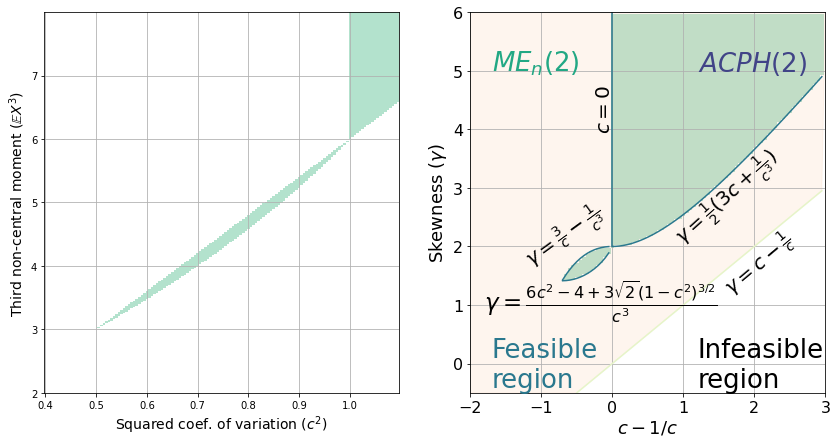

In [32]:
fig, axes = plt.subplots(figsize=(14, 7), nrows=1, ncols=2)
plot_acph2_boundary_in_cv2_m3_plane(ax=axes[0], step=0.005)
plot_acph2_boundary_in_normal_plane(ax=axes[1], step=0.05)
# ACPH_CV_ = np.asarray([x2cv(x) for x in ACPH_X])
# X_ = np.asarray([ACPH_X[i] for i in range(len(ACPH_CV_)) if ACPH_CV_[i] <= 1])
# 
# G2 = 
# axes[1].plot(X_, G1)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


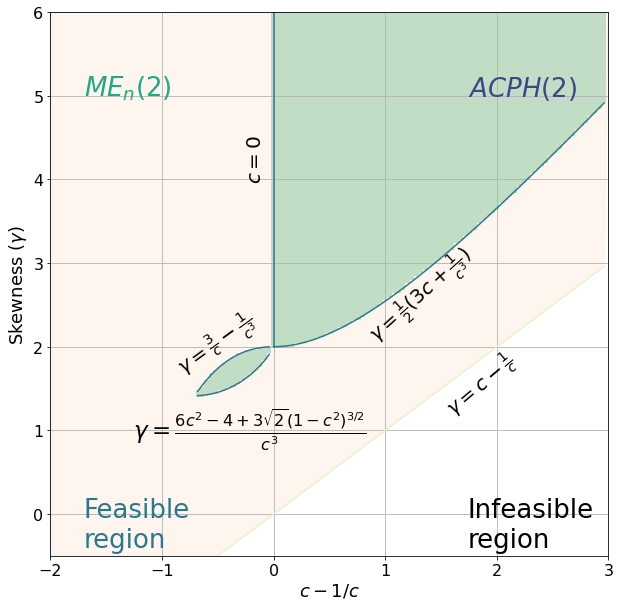

In [34]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_acph2_boundary_in_normal_plane(ax=ax, step=0.04, scale=0.7)
plt.savefig('output/ph_feasible_regions.eps')

## Study of MEn(2) order

As in paper [1], we will study the performance on the $(c-1/c, \gamma)$ plane, where $c$ is a coefficient of variation.

Note that equation $c - 1/c = x$ always have a single solution for $c > 0$:

$$
c - 1/c = x \; \Leftrightarrow \; c^2 - xc - 1 = 0 \Leftrightarrow c = \frac{x + \sqrt{x^2 + 4}}{2}
$$

In [7]:
raw_dists = [[
    fit_mern2([MEAN, get_noncentral_m2(MEAN, cv), get_noncentral_m3(MEAN, cv, y)])[0]
    if y > x else None for (x, cv) in zip(X, CV)
] for y in tqdm(Y)]

100%|██████████| 100/100 [00:00<00:00, 263.43it/s]


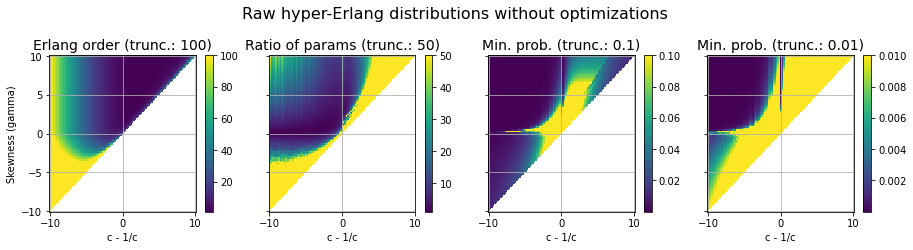

In [8]:
def plot_dist_params(distributions, title="", y_size=5):
    orders = np.zeros(shape=PLANE_SHAPE)
    min_p_1 = np.zeros(shape=PLANE_SHAPE)
    min_p_2 = np.zeros(shape=PLANE_SHAPE)
    max_ratio = np.zeros(shape=PLANE_SHAPE)
    for (i, j) in COORDS:
        dist = distributions[i][j]
        if dist is None:
            orders[i][j] = np.nan
            min_p_1[i][j] = np.nan
            min_p_2[i][j] = np.nan
            max_ratio[i][j] = np.nan
            continue
        assert isinstance(dist, HyperErlang)
        params = dist.params
        orders[i][j] = min(dist.order/2, 100)
        min_p_1[i][j] = min(min([p for p in dist.probs if p > 0]), 0.1)
        min_p_2[i][j] = min(min([p for p in dist.probs if p > 0]), 0.01)
        max_ratio[i][j] = min(max(params) / min(params), 50)

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=(13, y_size), ncols=4, nrows=1, sharey=True)
    im1 = ax1.pcolormesh(X, Y, orders)
    im2 = ax2.pcolormesh(X, Y, max_ratio)
    im3 = ax3.pcolormesh(X, Y, min_p_1)
    im4 = ax4.pcolormesh(X, Y, min_p_2)
    fig.suptitle(title, fontsize=16) 
    ax1.set_title('Erlang order (trunc.: 100)', fontsize=14)
    ax2.set_title('Ratio of params (trunc.: 50)', fontsize=14)
    ax3.set_title('Min. prob. (trunc.: 0.1)', fontsize=14)
    ax4.set_title('Min. prob. (trunc.: 0.01)', fontsize=14)
    ax1.set_ylabel('Skewness (gamma)')
    for im, ax in zip((im1, im2, im3, im4), (ax1, ax2, ax3, ax4)):
        fig.colorbar(im, ax=ax)
        ax.set_xlabel('c - 1/c')
        ax.grid()
    plt.tight_layout()    

#
# Plot original hyper-Erlang distributions without optimizations of ratios or probabilities.
#
plot_dist_params(raw_dists, "Raw hyper-Erlang distributions without optimizations", y_size=3.5)
plt.savefig('image.png')

In [15]:
MAX_INC = [2, 5, 10, 20, 30]
opt_ratio_dists = [[[
    fit_mern2([MEAN, get_noncentral_m2(MEAN, cv), get_noncentral_m3(MEAN, cv, y)], max_shape_inc=inc)[0]
    if y > x else None for (x, cv) in zip(X, CV)
] for y in Y] for inc in tqdm(MAX_INC)]

100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


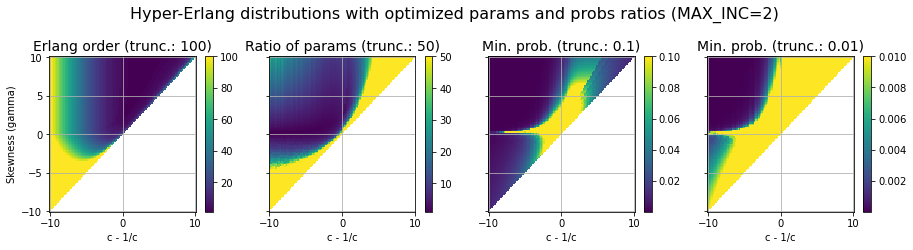

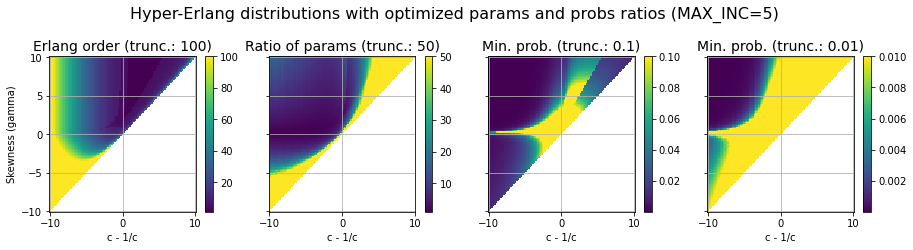

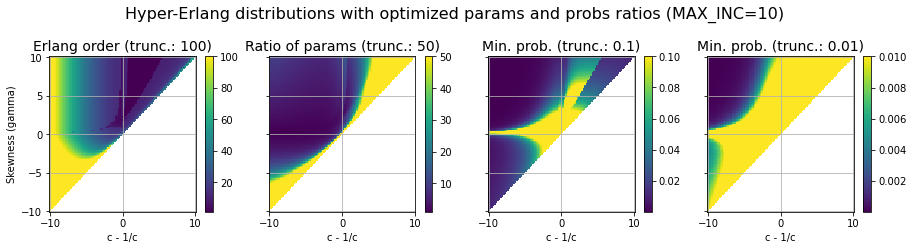

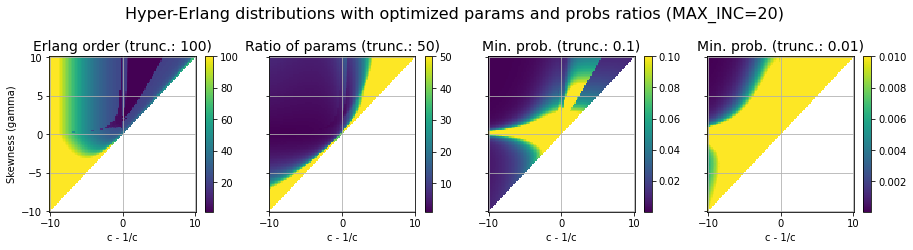

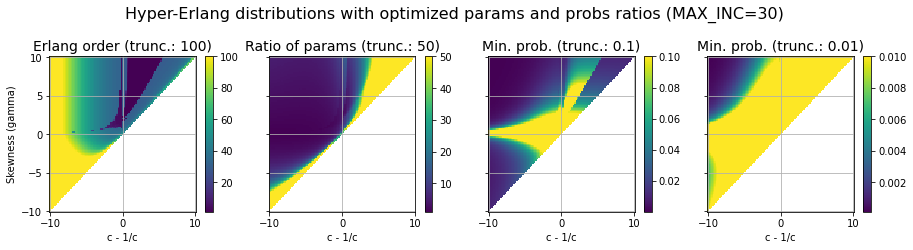

In [16]:
for i, inc in enumerate(MAX_INC):
    plot_dist_params(opt_ratio_dists[i], f"Hyper-Erlang distributions with optimized params and probs ratios (MAX_INC={inc})",
                     y_size=3.5)